In [26]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['HUGGINGFACE_RW_TOKEN'] = os.getenv('HUGGINGFACE_RW_TOKEN')
DB = "products_vectorstore"

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [7]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent

In [8]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)

In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [12]:
print(specialist.price(product))
print(frontier.price(product))

189.0
154.59


In [13]:
specialists = []
frontiers = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████| 250/250 [27:56<00:00,  6.71s/it]


In [16]:
mins = [min(s,f) for s,f in zip(specialists, frontiers)]
maxes = [max(s,f) for s,f in zip(specialists, frontiers)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    #'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [17]:
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.23
Frontier: 0.24
Min: -0.27
Max: 0.74
Intercept=6.77


In [18]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [27]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [33]:
ensemble.price(product)

185.35410139236384

In [34]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $396.55 Truth: $374.41 Error: $22.14 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $225.17 Truth: $225.11 Error: $0.06 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.94 Truth: $61.68 Error: $10.74 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $533.07 Truth: $599.99 Error: $66.92 SLE: 0.01 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $24.82 Truth: $16.99 Error: $7.83 SLE: 0.13 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $24.79 Truth: $31.99 Error: $7.20 SLE: 0.06 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $133.57 Truth: $101.79 Error: $31.78 SLE: 0.07 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $386.45 Truth: $289.00 Error: $97.45 SLE: 0.08 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $926.57 Truth: $635.86 Error: $290.71 SLE: 0.14 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $63.43 Truth: $65.99 Error: $2.56 SLE: 0.00 Item:

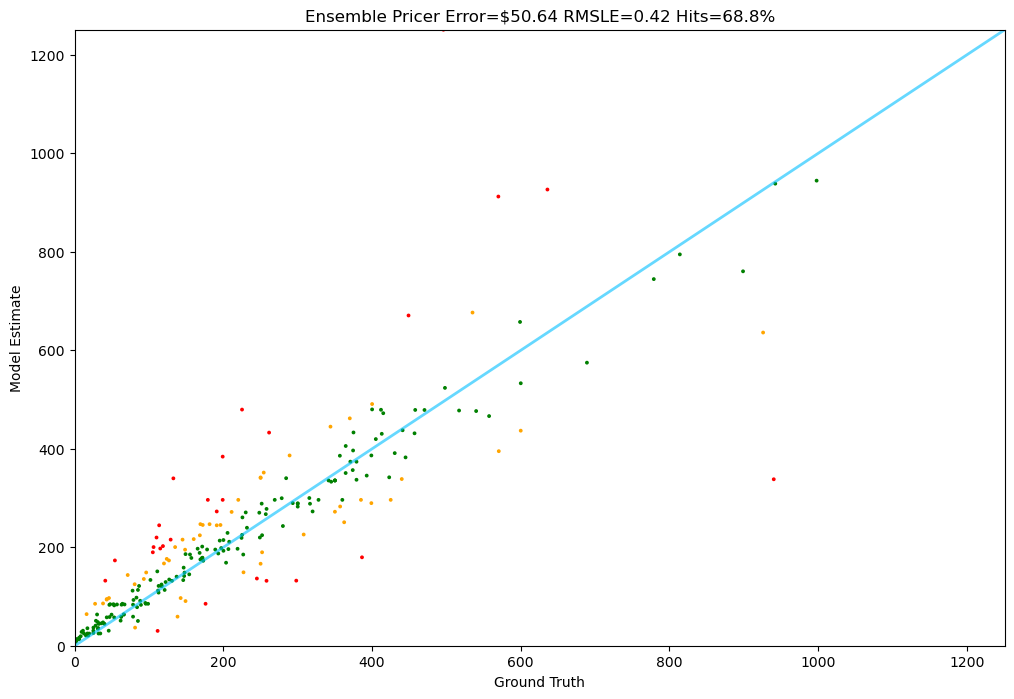

In [35]:
Tester.test(ensemble_pricer, test)